In [1]:
import os
import pickle
import collections
import operator
import time
import itertools
import textwrap

import brightway2 as bw
import numpy as np
import scipy.sparse as sp
import pypardiso as pp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns 
import multiprocessing as mp
%matplotlib inline

In [40]:
with open('../data/tech_vector/full_index.p', 'rb') as i:
    full_index = pickle.load(i)
with open('../data/final_matrix/technosphere_matrix_local_mar_csc_abs.p', 'rb') as i:
    tec_mat = pickle.load(i)
with open('../data/final_matrix/biosphere_index.p', 'rb') as i:
    bio_index = pickle.load(i)
with open('../data/final_matrix/biosphere_matrix_csc.p', 'rb') as i:
    bio_mat = pickle.load(i)

In [41]:
cfs_dict = {}
with open('../data/final_matrix/CF_aware_glo.p', 'rb') as i:
    cfs_dict['aware_glo'] = pd.read_pickle(i)
with open('../data/final_matrix/CF_aware.p', 'rb') as i:
    cfs_dict['aware_reg'] = pd.read_pickle(i)
with open('../data/final_matrix/CF_pslglo_glo.p', 'rb') as i:
    cfs_dict['pslglo_glo'] = pd.read_pickle(i)
with open('../data/final_matrix/CF_pslglo.p', 'rb') as i:
    cfs_dict['pslglo_reg'] = pd.read_pickle(i)
with open('../data/final_matrix/CF_ipcc.p', 'rb') as i:
    cfs_dict['ipcc'] = pd.read_pickle(i)
with open('../data/final_matrix/CF_recipe.p', 'rb') as i:
    cfs_dict['recipe'] = pd.read_pickle(i)

In [42]:
cfs_ei_dict = {}
with open('../data/final_matrix/CF_aware_glo_eco.p', 'rb') as i:
    cfs_ei_dict['aware_glo_ei'] = pd.read_pickle(i)
with open('../data/final_matrix/CF_pslglo_glo_eco.p', 'rb') as i:
    cfs_ei_dict['psl_glo_ei'] = pd.read_pickle(i)

In [43]:
with open('../data/tech_vector/full_reference_dataset_dict.p', 'rb') as i: #{full_index: code of ref ds}
    ref_ds_dict = pickle.load(i)
inv_ref_ds_dict = collections.defaultdict(dict)
for full_i, ref_ds in ref_ds_dict.items():
    inv_ref_ds_dict[ref_ds][full_i[0]] = full_i
inv_ref_ds_dict = dict(inv_ref_ds_dict) #{code:{reg: (reg, mr_key)}}

In [44]:
with open('../data/lcia_case_studies/full_index_country.p', 'rb') as i:
    full_index_country = pickle.load(i)
with open('../data/lcia_case_studies/iot_sec_indexer_TO_isic_code.p', 'rb') as i:
    iot_sec_indexer_TO_isic_code = pickle.load(i)
with open('../data/lcia_case_studies/isic_code_to_name.p', 'rb') as i:
    isic_code_to_name = pickle.load(i)
with open('../data/lcia_case_studies/full_index_isic_sector.p', 'rb') as i:
    full_index_isic_sector = pickle.load(i)
with open('../data/lcia_case_studies/full_index_referprod.p', 'rb') as i:
    full_index_referprod = pickle.load(i)
with open('../data/lcia_case_studies/full_index_dsname.p', 'rb') as i:
    full_index_dsname = pickle.load(i)
with open('../data/lcia_case_studies/full_index_unit.p', 'rb') as i:
    full_index_unit = pickle.load(i)
with open('../data/lcia_case_studies/full_index_loc.p', 'rb') as i: #location of reference dataset
    full_index_loc = pickle.load(i)

In [45]:
with open('../data/sector_matching/isic_TO_exio_name.p', 'rb') as i:
    isic_TO_exio_name = pickle.load(i)
with open('../data/tech_vector/datasets_no_prodmix_with_new_items.p', 'rb') as i:
    datasets = pickle.load(i)

In [46]:
%%time
bw.projects.set_current('regeco')
db = bw.Database('ecoinvent 3.7.1_cutoff_ecoSpold02')

CPU times: user 57.1 ms, sys: 23.7 ms, total: 80.8 ms
Wall time: 79.3 ms


In [47]:
%%time 
solver = pp.PyPardisoSolver()
solver.factorize(tec_mat)

CPU times: user 10h 13min 22s, sys: 1min 27s, total: 10h 14min 50s
Wall time: 18min 43s


In [117]:
demand = {('CH', '00e4a6354bc9c5d21e73d00730e50071'): 1}
demand_arr = np.zeros(tec_mat.shape[0])
for i, v in demand.items():
    demand_arr[full_index.index(i)] = v

In [123]:
%time supply = solver.solve(tec_mat, demand_arr)

CPU times: user 38.5 s, sys: 26 s, total: 1min 4s
Wall time: 3.65 s


Generate a file showing the matching between datasets in the original and regionalized ecoinvent.

In [6]:
with open('../data/tech_vector/full_index.p', 'rb') as i:
    full_index = pickle.load(i)
with open('../data/tech_vector/full_reference_dataset_dict.p', 'rb') as i: #{full_index: code of ref ds}
    ref_ds_dict = pickle.load(i)

In [7]:
%%time
bw.projects.set_current('regeco')
db = bw.Database('ecoinvent 3.7.1_cutoff_ecoSpold02')

CPU times: user 36.2 ms, sys: 3.28 ms, total: 39.4 ms
Wall time: 38 ms


In [8]:
df = pd.DataFrame(columns=['Full index','Name','Reference product','Location','Classification'])
for n,i in enumerate(full_index):
    ds_old_ei = db.get(ref_ds_dict[i])
    df.loc[n,'Name'] = ds_old_ei['name']
    df.loc[n,'Location'] = ds_old_ei['location']
    df.loc[n,'Classification'] = ds_old_ei['classifications']
    df.loc[n,'Reference product'] = ds_old_ei['reference product']

full_index_str = [','.join([i[0],i[1]]) for i in full_index]
df['Full index'] = full_index_str

In [15]:
df.to_excel('../data/lcia_results_AllDs/datasets_in_reg_ecoinvent_and_ref_dataset_in_ecoinvent.xlsx')

# LCA

In [48]:
class RegionalizedLCA:
    def __init__(self, demand, method=None, solver=None):
        self.demand = demand
        self.method = method
        self.solver = solver
        self.technosphere_matrix = tec_mat
        self.biosphere_matrix = bio_mat
        self.full_index = full_index
        self.full_index_country = full_index_country
        self.full_index_isic_sector = full_index_isic_sector
        
        self.regions = sorted(list({i[0] for i in self.full_index_country}))  # for supply side aggregation
        self.sectors = sorted(list({i for i in self.full_index_isic_sector})) # 92 supply sectors
        self.region_id_mask = np.array([self.regions.index(r[0]) for r in self.full_index_country])
        self.sector_id_mask = np.array([self.sectors.index(r) for r in self.full_index_isic_sector])
        self.cfs = cfs_dict
        self.cfs_ei = cfs_ei_dict
        self.inv_ref_ds_dict = inv_ref_ds_dict
        
              
    def build_demand_array(self):
        demand_arr = np.zeros(self.technosphere_matrix.shape[0])
        for i, v in self.demand.items():
            demand_arr[self.full_index.index(i)] = v
        return demand_arr
    
    def lci(self):
        demand = self.build_demand_array()
        self.supply = solver.solve(self.technosphere_matrix, demand)
    
    def lcia(self):
        if not self.method:
            raise UserWarning('must choose method')
        self.inventory = self.biosphere_matrix *sp.diags(self.supply)
        cf_mat = self.cfs[self.method]
        if operator.eq(*cf_mat.shape):
            self.characterized_inventory = cf_mat*self.inventory #multiply array by vector
        else:
            self.characterized_inventory = cf_mat.multiply(self.inventory) #multiply array by scalar
            
    
    def switch_method(self, method):
        assert method in self.cfs, f'{method} not available'
        self.method = method
        
    def lcia_all(self):
        scores_dict = {}
        for method in self.cfs:
            self.switch_method(method)
            self.lcia()
            scores_dict[method] = self.characterized_inventory.sum()
        return scores_dict
    
    def ecoinvent_lca(self, activity):
        ipcc = ('IPCC 2013', 'climate change', 'GWP 100a')
        recipe =('ReCiPe Endpoint (H,A)', 'total', 'total')
        eco_lca = bw.LCA({activity:1}, ipcc)
        eco_lca.lci()
        eco_lca.lcia()
        eco_res = {}
        eco_res['ipcc'] = eco_lca.score
        eco_lca.switch_method(recipe)
        eco_lca.redo_lcia()
        eco_res['recipe'] = eco_lca.score
        inv = eco_lca.inventory
        for met in self.cfs_ei:
            ChaInv = self.cfs_ei[met]*inv 
            eco_res[met] = ChaInv.sum()
        res = {}
        name = 'ecoinvent' + ' '+ activity.as_dict()['location']
        res[name] = eco_res
        return res

In [49]:
%%time
demand = {('CH', '00e4a6354bc9c5d21e73d00730e50071'): 1}
lca = RegionalizedLCA(demand=demand, method='ipcc') 

CPU times: user 3.93 s, sys: 115 ms, total: 4.05 s
Wall time: 689 ms


In [50]:
len(full_index)

335099

In [51]:
from random import sample
target_ind = sorted(sample(full_index,500))
with open('../data/lcia_results_AllDs/target_ind_random500.p', 'wb') as o:
    pickle.dump(target_ind, o)

In [52]:
with open('../data/lcia_results_AllDs/target_ind_random500.p', 'rb') as i:
    target_ind = pickle.load(i)
target_ind[-10:]

[('ZA', '3b0177f09f925a694082d896c3d144c6'),
 ('ZA', '41601559cc2a29ce626dbf0b1dabb661'),
 ('ZA', '4765206e0fb51688d9d1ec0e8dedea30'),
 ('ZA', '98def16ef460ed1c767966f73f8aa6f1'),
 ('ZA', '9f2d044c5c49a2716f722c1088ccbe79'),
 ('ZA', 'a2e2608ef54630c46461bda3db981d77'),
 ('ZA', 'a51289459c279dea4d40bfc3b7a2929d'),
 ('ZA', 'a983c13c6e39534ba66e7e6f70a970be'),
 ('ZA', 'bbd9fcae5bf68412516d188064b587db'),
 ('ZA', 'c7c49317b81cc7a0299e8e7cbb242178')]

impacts based on reg ecoinvent

In [53]:
%%time
def get_reg_scores(target):
    print(target_ind.index(target),',')
    lca.demand = {target: 1}
    lca.lci()
    scores = lca.lcia_all()
    return (target, scores)
with mp.Pool(processes=30) as pool:
    region_scores_list = pool.map(get_reg_scores, target_ind)
with open('../data/lcia_results_AllDs/region_scores_list_random500.p', 'wb') as o:
    pickle.dump(region_scores_list, o)

10 ,
70 ,
75 ,
80 ,
135 ,
65 ,
55 ,
120 ,
130 ,
15 ,
115 ,
60 ,
45 ,
5 ,
125 ,
110 ,
85 ,
0 ,
100 ,
105 ,
90 ,
50 ,
20 ,
40 ,
145 ,
140 ,
25 ,
95 ,
35 ,
30 ,
91 ,
146 ,
41 ,
26 ,
126 ,
106 ,
131 ,
136 ,
71 ,
56 ,
61 ,
121 ,
21 ,
141 ,
86 ,
101 ,
111 ,
31 ,
96 ,
76 ,
116 ,
147 ,
66 ,
81 ,
46 ,
51 ,
36 ,
6 ,
42 ,
1 ,
16 ,
92 ,
11 ,
27 ,
43 ,
17 ,
7 ,
12 ,
93 ,
2 ,
148 ,
44 ,
107 ,
18 ,
13 ,
28 ,
19 ,
8 ,
127 ,
3 ,
149 ,
150 ,
94 ,
132 ,
29 ,
4 ,
137 ,
108 ,
155 ,
160 ,
14 ,
165 ,
170 ,
128 ,
133 ,
102 ,
109 ,
9 ,
151 ,
175 ,
138 ,
37 ,
180 ,
185 ,
176 ,
156 ,
190 ,
161 ,
181 ,
129 ,
134 ,
103 ,
157 ,
177 ,
171 ,
166 ,
139 ,
191 ,
152 ,
38 ,
167 ,
162 ,
82 ,
195 ,
186 ,
182 ,
117 ,
192 ,
153 ,
62 ,
67 ,
178 ,
122 ,
104 ,
200 ,
87 ,
172 ,
158 ,
205 ,
163 ,
187 ,
112 ,
183 ,
32 ,
39 ,
72 ,
196 ,
193 ,
168 ,
159 ,
57 ,
210 ,
118 ,
154 ,
179 ,
188 ,
201 ,
47 ,
22 ,
173 ,
83 ,
184 ,
97 ,
206 ,
194 ,
169 ,
164 ,
197 ,
215 ,
220 ,
63 ,
52 ,
225 ,
68 ,
123 ,
189 ,
119 ,
142 ,
230 ,
211 ,
88 ,
113

In [84]:
with open('../data/lcia_results_AllDs/region_scores_list_random10000.p', 'rb') as i:
    region_scores_list = pickle.load(i)
res = {}#{ind:{impact:value}}
for i in region_scores_list:#[(ind, {impact:value}, exitCode)]
    res[i[0]] = i[1]
res_df = pd.DataFrame(res)
res_df

AE                               AM  \
           ff50a738ace04f34f3007e7a6cf86add b8120f70bfd6d18e85e7a4b2b8aa95f2   
aware_glo                      4.330781e-02                     7.471025e-02   
aware_reg                      4.130873e-03                     3.020525e-02   
pslglo_glo                     1.928485e-17                     2.283901e-17   
pslglo_reg                     8.863700e-18                     1.104241e-17   
ipcc                           5.533906e-01                     2.912844e-01   
recipe                         5.458899e-02                     2.968911e-02   

                                         AT                                   \
           00e6dda4841042b28125b4254f7f3eef 014b90e304ee23efe60c07170477111d   
aware_glo                      2.385209e-03                     8.787378e-01   
aware_reg                      1.889143e-04                     1.636607e-01   
pslglo_glo                     2.541768e-16                     6.424977e-15   
pslglo_reg                     6.000812e-16                     2.850927e-15   
ipcc                           6.563007e-03                     8.924154e-01   
recipe                         3.449704e-03                     3.175494e-01   

                                                                              \
           032e797149ea04c6444ecef98da9e22a 0441e14119fbc991f84a850711de0d3c   
aware_glo                      1.649263e+01                     5.980309e-01   
aware_reg                      5.660038e+00                     5.953879e-02   
pslglo_glo                     1.881827e-15                     2.908137e-16   
pslglo_reg                     1.381195e-15                     2.136772e-16   
ipcc                           9.287463e+00                     7.067645e+00   
recipe                         1.117401e+00                     4.260883e-01   

                                                                              \
           0442f6c8836c6769933cd54222f5a103 06479137c022a734f01a7b80de7659f7   
aware_glo                      6.045465e-02                     6.387042e+00   
aware_reg                      9.744338e-03                     2.354342e+00   
pslglo_glo                     7.475066e-17                     1.512577e-15   
pslglo_reg                     7.563565e-17                     1.130179e-15   
ipcc                           3.403711e-01                     1.240165e+01   
recipe                         2.654216e-02                     1.109705e+00   

                                                                              \
           0714e0beb123fe123bd560fa22ea8beb 0b72f9b0d36b9780c0efc7dfa3c348e2   
aware_glo                     -4.178150e+01                     2.434012e+00   
aware_reg                      4.596330e-01                     7.176198e-01   
pslglo_glo                     1.454521e-15                     3.463257e-16   
pslglo_reg                     9.889518e-16                     2.571205e-16   
ipcc                           9.100962e+00                     3.420297e+00   
recipe                         1.075396e+00                     4.807686e-01   

            ...                               ZA  \
            ... f8bed48e19c842b1a57cc7f74b4decb5   
aware_glo   ...                     2.675057e+00   
aware_reg   ...                     2.131580e+00   
pslglo_glo  ...                     1.921393e-15   
pslglo_reg  ...                     3.709429e-15   
ipcc        ...                     9.081781e+00   
recipe      ...                     1.414982e+00   

                                                                              \
           f8d36ecfa9e0778c72a439616d9a5206 fa5f508e738bee6b4cebf21f1dd3ef88   
aware_glo                      3.783926e-02                     3.050837e-02   
aware_reg                      2.914182e-02                     1.959892e-02   
pslglo_glo                     4.294533e-18                     4.016798e-17   
pslglo_reg         

In [96]:
os. getcwd()

'/home/sipeng2/Msc_RA/RegEcoData/08_Reg_VS_Eco_analysis_crop_rev_mrio'

impacts based on original ecoinvent

In [72]:
with open('../data/lcia_results_AllDs/target_ind_random10000.p', 'rb') as i:
    target_ind = pickle.load(i)

In [73]:
ds_code_old_ei = {d['code'] for d in db}
target_ds_code_ei = []
ind_TO_ds_old_ei = {}
for i in target_ind:
    target_ds_code_ei.append(ref_ds_dict[i])
    if ref_ds_dict[i] not in ds_code_old_ei:
        print(i)
    ds_old_ei = db.get(ref_ds_dict[i])
    ind_TO_ds_old_ei[i] = ds_old_ei

In [74]:
%%time
res_old_ei_df = pd.DataFrame()
for ind,ds_old_ei in ind_TO_ds_old_ei.items():
    res = lca.ecoinvent_lca(ds_old_ei) #{reg:{impact:value}}
    res_rev = {}
    for reg,impact in res.items():
        res_rev[ind] = impact#{ind:{impact:value}}
        res_df0 = pd.DataFrame(res_rev)
        res_old_ei_df = pd.concat([res_old_ei_df, res_df0], axis=1)

CPU times: user 16h 49min 5s, sys: 40min 53s, total: 17h 29min 58s
Wall time: 47min 44s


In [77]:
with open('../data/lcia_results_AllDs/res_old_ei_df_random10000.p', 'wb') as o:
    pickle.dump(res_old_ei_df, o)

original ecoinvent VS reg ecoinvent

In [85]:
reg = res_df.T[['pslglo_glo']].rename(columns={'pslglo_glo':'reg'})
eco = res_old_ei_df[target_ind].T[['psl_glo_ei']].rename(columns={'psl_glo_ei':'eco'})
scores_df_psl = pd.concat([reg,eco], axis=1)
reg = res_df.T[['aware_glo']].rename(columns={'aware_glo':'reg'})
eco = res_old_ei_df[target_ind].T[['aware_glo_ei']].rename(columns={'aware_glo_ei':'eco'})
scores_df_aware = pd.concat([reg,eco], axis=1)

reg = res_df.T[['ipcc']].rename(columns={'ipcc':'reg'})
eco = res_old_ei_df[target_ind].T[['ipcc']].rename(columns={'ipcc':'eco'})
scores_df_ipcc = pd.concat([reg,eco], axis=1)
reg = res_df.T[['recipe']].rename(columns={'recipe':'reg'})
eco = res_old_ei_df[target_ind].T[['recipe']].rename(columns={'recipe':'eco'})
scores_df_recipe = pd.concat([reg,eco], axis=1)

In [86]:
scores_df_aware['rel'] = scores_df_aware['reg']/scores_df_aware['eco']
scores_df_psl['rel'] = scores_df_psl['reg']/scores_df_psl['eco']
scores_df_ipcc['rel'] = scores_df_ipcc['reg']/scores_df_ipcc['eco']
scores_df_recipe['rel'] = scores_df_recipe['reg']/scores_df_recipe['eco']

In [87]:
def rev_scores_df(scores_df):
    scores_df['rel'] = abs(scores_df['rel'].fillna(1))
    scores_df = scores_df.sort_values(by=['rel'], ascending=False)
    scores_df['ref ds name'] = [ind_TO_ds_old_ei[i]['name'] for i in scores_df.index]
    scores_df['ref ds location'] = [ind_TO_ds_old_ei[i]['location'] for i in scores_df.index]
    scores_df['ref ds classification'] = [ind_TO_ds_old_ei[i]['classifications'] for i in scores_df.index]
    return scores_df

scores_df_psl = rev_scores_df(scores_df_psl)
scores_df_psl.to_csv('../data/lcia_results_AllDs/scores_df_psl.csv')

scores_df_aware = rev_scores_df(scores_df_aware)
scores_df_aware.to_csv('../data/lcia_results_AllDs/scores_df_aware.csv')

scores_df_ipcc = rev_scores_df(scores_df_ipcc)
scores_df_ipcc.to_csv('../data/lcia_results_AllDs/scores_df_ipcc.csv')

scores_df_recipe = rev_scores_df(scores_df_recipe)
scores_df_recipe.to_csv('../data/lcia_results_AllDs/scores_df_recipe.csv')

In [ ]:
scores_df_psl = pd.read_csv('../data/lcia_results_AllDs/scores_df_psl.csv', keep_default_na=False)
scores_df_aware = pd.read_csv('../data/lcia_results_AllDs/scores_df_aware.csv', keep_default_na=False)
scores_df_ipcc = pd.read_csv('../data/lcia_results_AllDs/scores_df_ipcc.csv', keep_default_na=False)
scores_df_recipe = pd.read_csv('../data/lcia_results_AllDs/scores_df_recipe.csv', keep_default_na=False)

/home/sipeng2/miniconda3/envs/reg_eco/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


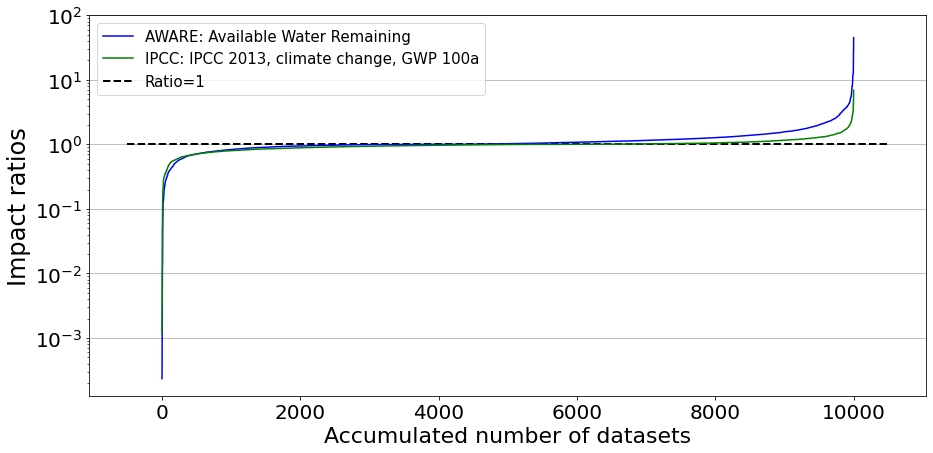

In [107]:
f, ax = plt.subplots(1, 1, figsize=(15, 7))
# ax.plot(np.sort(scores_df_psl['rel'].values), label='PSL: Global Potential Species Loss from land use', alpha=1, color='r')
ax.plot(np.sort(scores_df_aware['rel'].values), label='AWARE: Available Water Remaining', alpha=1, color='b')
ax.plot(np.sort(scores_df_ipcc['rel'].values), label='IPCC: IPCC 2013, climate change, GWP 100a', alpha=1, color='g')
# ax.plot(np.sort(scores_df_recipe['rel'].values), label='Recipe: ReCiPe Endpoint (H,A), total, total', alpha=1, color='y')
ax.hlines(1, *ax.get_xlim(), color='black', label='Ratio=1', linestyle='--', linewidth=2)
ax.legend(fontsize=15)
ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax.grid(axis='y')
ax.set_axisbelow(True)
# ax.set_ylabel(r'$\mathrm{\frac{New\ impact\ score\ (regionalized\ ecoinvent)}{Reference\ impact\ score\ (ecoinvent)}}$',fontsize=24)
ax.set_ylabel(r'Impact ratios',fontsize=24)
ax.set_xlabel(r'Accumulated number of datasets',fontsize=22)
ax.set_yscale('log')

ax.set_ylim(0, 100)  # most of the data
ax.xaxis.tick_bottom()

f.savefig('../plots/impact_ratios_random10000.png')

/home/sipeng2/miniconda3/envs/reg_eco/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


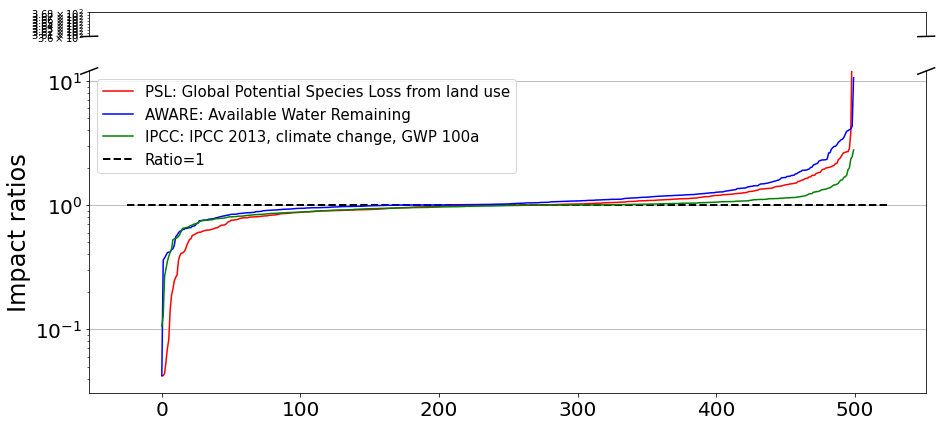

In [70]:
f, (ax2, ax) = plt.subplots(2, 1, sharex=True,figsize=(15, 7), gridspec_kw={'height_ratios':[0.15, 2]})
ax.plot(np.sort(scores_df_psl['rel'].values), label='PSL: Global Potential Species Loss from land use', alpha=1, color='r')
ax.plot(np.sort(scores_df_aware['rel'].values), label='AWARE: Available Water Remaining', alpha=1, color='b')
ax.plot(np.sort(scores_df_ipcc['rel'].values), label='IPCC: IPCC 2013, climate change, GWP 100a', alpha=1, color='g')
# ax.plot(np.sort(scores_df_recipe['rel'].values), label='Recipe: ReCiPe Endpoint (H,A), total, total', alpha=1, color='y')
ax.hlines(1, *ax.get_xlim(), color='black', label='Ratio=1', linestyle='--', linewidth=2)
ax.legend(fontsize=15)
ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )
ax.grid(axis='y')
ax.set_axisbelow(True)
# ax.set_ylabel(r'$\mathrm{\frac{New\ impact\ score\ (regionalized\ ecoinvent)}{Reference\ impact\ score\ (ecoinvent)}}$',fontsize=24)
ax.set_ylabel(r'Impact ratios',fontsize=24)
ax.set_yscale('log')

ax2.plot(np.sort(scores_df_psl['rel'].values), label='PSL: Global Potential Species Loss from land use', alpha=1, color='r')
ax2.plot(np.sort(scores_df_aware['rel'].values), label='AWARE: Available Water Remaining', alpha=1, color='b')
ax2.plot(np.sort(scores_df_ipcc['rel'].values), label='IPCC: IPCC 2013, climate change, GWP 100a', alpha=1, color='g')
# ax2.plot(np.sort(scores_df_recipe['rel'].values), label='Recipe: ReCiPe Endpoint (H,A), total, total', alpha=1, color='y')
ax2.tick_params(axis='y', labelsize=20 )
ax2.grid(axis='y')
ax2.set_axisbelow(True)
ax2.set_yscale('log')

ax.set_ylim(0, 12)  # most of the data
ax2.set_ylim(360, 368)  # outliers only
# ax.set_xlim(-10, 1010)

ax2.spines['bottom'].set_visible(False)
ax2.tick_params(labeltop=False)# don't put tick labels at the top
ax2.tick_params(labelbottom=False)
ax2.tick_params(bottom=False)
ax.spines['top'].set_visible(False)
ax.xaxis.tick_bottom()


d = 0.01  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax.transAxes, color='k', clip_on=False)  # switch to the bottom axes
ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

In [ ]:
'''need check'''
scores_df_ipcc = pd.concat([res_old_ei_df.T['ipcc'], res_df.T['ipcc']], axis=1)
scores_df_recipe = pd.concat([res_old_ei_df.T['recipe'], res_df.T['recipe']], axis=1)

In [ ]:
scores_df_recipe['rel'] = scores_df_recipe['reg']/scores_df_recipe['eco']
scores_df_ipcc['rel'] = scores_df_ipcc['reg']/scores_df_ipcc['eco']

In [ ]:
scores_df_recipe = scores_df_recipe.sort_values(by=['rel'])
part = scores_df_recipe.iloc[0:5,:]
part

In [ ]:
[(db.get(ref_ds_dict[i]).as_dict()['name'],db.get(ref_ds_dict[i]).as_dict()['classifications'][0]) 
 for i in part.index]

In [ ]:
rel_change_recipe = np.sort(scores_df_recipe['rel'].values)
rel_change_recipe[np.isnan(rel_change_recipe)] = 1
rel_change_recipe.sort()

In [ ]:
scores_df_ipcc = scores_df_ipcc.sort_values(by=['rel'])
part = scores_df_ipcc.iloc[0:5,:]
part

In [ ]:
[(db.get(ref_ds_dict[i]).as_dict()['name'],db.get(ref_ds_dict[i]).as_dict()['classifications'][0]) 
 for i in scores_df_ipcc.index]

In [ ]:
rel_change_ipcc = np.sort(scores_df_ipcc['rel'].values)
print(rel_change_ipcc.shape)
rel_change_ipcc[np.isnan(rel_change_ipcc)] = 1 # why?
rel_change_ipcc.sort()

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(rel_change_ipcc, label='ipcc', alpha=0.7)
ax.plot(rel_change_recipe[:-1], label='recipe', alpha=0.7)
ax.hlines(1, *ax.get_xlim(), color='grey', label='even', linestyle='--', linewidth=1)
ax.legend()
fig.tight_layout();